<b><h1>Optimization Example in Hyperopt</h1></b>
Formulating an optimization problem in Hyperopt requires four parts:<br>
    - <b>Objective Function: </b>takes in an input and returns a loss to minimize<br>
    - <b>Domain space:</b> the range of input values to evaluate<br>
    - <b>Optimization Algorithm:</b> the method used to construct the surrogate function and choose the next values to evaluate<br>
    - <b>Results:</b> score, value pairs that the algorithm uses to build the model<br>

In [4]:
# Good old pandas and numpy
import pandas as pd
import numpy as np

# Unfortunately I'm still using matplotlib for graphs
import matplotlib.pyplot as plt
import seaborn as sns

<b>Objective Function</b><br>
The objective function can be any function that returns a real value that we want to minimize.<br>

In [1]:
import numpy as np

def objective(x):
    """Objective function to minimize"""
    
    # Create the polynomial object
    f = np.poly1d([1, -2, -28, 28, 12, -26, 100])

    # Return the value of the polynomial
    return f(x) * 0.05

Minimum of -219.8012 occurs at 4.8779


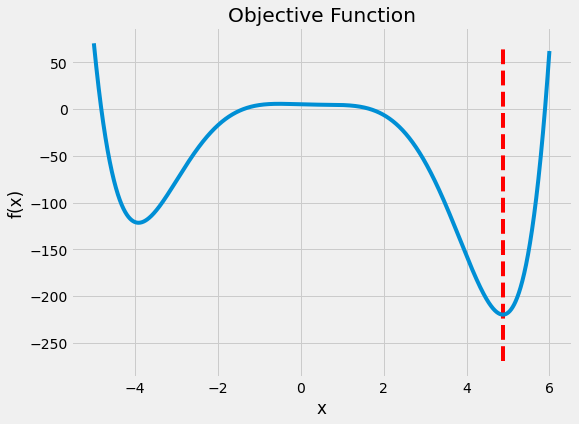

In [7]:
# Space over which to evluate the function is -5 to 6
x = np.linspace(-5, 6, 10000)
y = objective(x)

miny = min(y)
minx = x[np.argmin(y)]

# Visualize the function
plt.figure(figsize = (8, 6))
plt.style.use('fivethirtyeight')
plt.title('Objective Function'); plt.xlabel('x'); plt.ylabel('f(x)')
plt.vlines(minx, min(y)- 50, max(y), linestyles = '--', colors = 'r')
plt.plot(x, y);

# Print out the minimum of the function and value
print('Minimum of %0.4f occurs at %0.4f' % (miny, minx))

<b>Domain Space</b><br>
The domain space is the input values over which we want to search.<br>

In [18]:
from hyperopt.pyll.stochastic import sample

def plot_distr(func, title='Domain Space'):
    samples = []

    # Sample 10000 values from the range
    for _ in range(10000):
        samples.append(sample(func))

    plt.figure()
    # Histogram of the values
    plt.hist(samples, bins = 20, edgecolor = 'black'); 
    plt.xlabel('x'); plt.ylabel('Frequency'); plt.title(title);

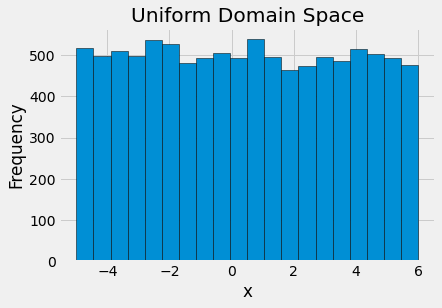

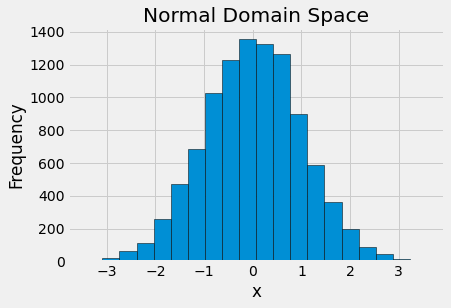

In [19]:
from hyperopt import hp
# Create the domain space
space = hp.uniform('x', -5, 6)
space_normal = hp.normal('x', 0, 1)

plot_distr(space, 'Uniform Domain Space')
plot_distr(space_normal, 'Normal Domain Space')

<b>Optimization Algorithm</b><br>
We are using the Tree-structured Parzen Estimator model, and we can have Hyperopt configure it for us using the suggest method.<br>

In [20]:
from hyperopt import tpe
# Create the algorithm
tpe_algo = tpe.suggest

<b>Results (Trials)</b><br>
This is not strictly necessary as Hyperopt keeps track of the results for the algorithm internally. However, if we want to inspect the progression of the alogorithm, we need to create a Trials object that will record the values and the scores.<br>

In [21]:
from hyperopt import Trials
# Create a trials object
tpe_trials = Trials()

<b><h3>Optimization</h3></b><br>
Now that the problem is defined, we can minimize our objective function!<br>
To do so, we use the <i>fmin</i> function that takes the four parts above, as well as a maximum number of trials:

In [22]:
from hyperopt import fmin

# Run 2000 evals with the tpe algorithm
tpe_best = fmin(fn=objective, space=space, 
                algo=tpe_algo, trials=tpe_trials, 
                max_evals=2000)

print(tpe_best)

100%|██████████| 2000/2000 [00:24<00:00, 82.45trial/s, best loss: -219.80118028424846] 
{'x': 4.877704459477955}


In [32]:
# Dataframe of results from optimization
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], 
                            'iteration': tpe_trials.idxs_vals[0]['x'],
                            'x': tpe_trials.idxs_vals[1]['x']})



tpe_results['rolling_average_x'] = tpe_results['x'].rolling(50).mean().fillna(method = 'bfill')
tpe_results['rolling_average_loss'] = tpe_results['loss'].rolling(50).mean().fillna(method = 'bfill')
tpe_results.loc[tpe_results['loss'] <= -218]

,loss,iteration,x,rolling_average_x,rolling_average_loss
7,-219.748187,7,4.898238,2.216104,-79.845035
25,-219.051903,25,4.952677,2.216104,-79.845035
51,-218.350902,51,4.769440,2.207622,-80.211458
63,-219.800600,63,4.880287,2.381448,-80.144897
65,-219.771301,65,4.862895,2.640175,-84.575716
...,...,...,...,...,...
1972,-219.791640,1972,4.886697,4.862017,-192.023604
1979,-219.523131,1979,4.831290,4.869289,-203.207305
1985,-219.796158,1985,4.884357,4.850359,-201.659459
1991,-218.845206,1991,4.962132,4.869159,-197.915571


Over time, the input values cluster around the optimal indicated by the red line. This is a simple problem, so the algorithm does not have much trouble finding the best value of x.

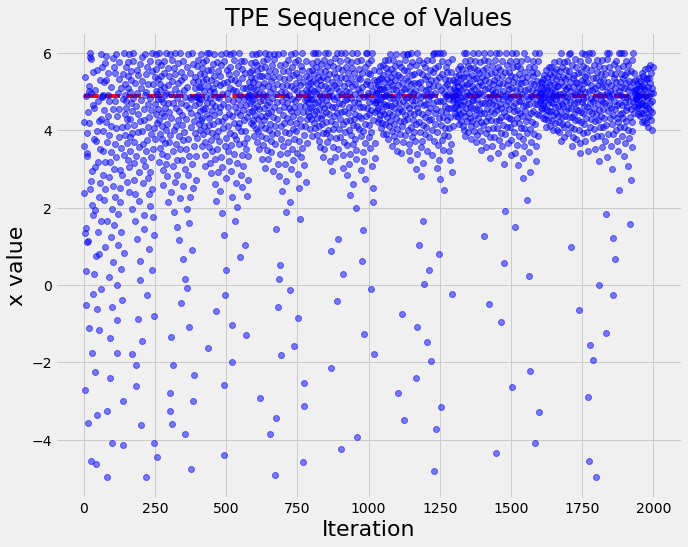

In [28]:
plt.figure(figsize = (10, 8))
plt.plot(tpe_results['iteration'], tpe_results['x'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('x value', size = 22); plt.title('TPE Sequence of Values', size = 24);
plt.hlines(minx, 0, 2000, linestyles = '--', colors = 'r');

We can also plot the histogram to see the distribution of values tried.

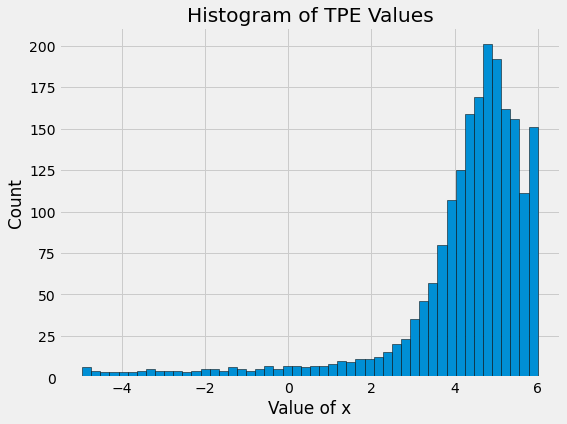

In [33]:
plt.figure(figsize = (8, 6))
plt.hist(tpe_results['x'], bins = 50, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of x'); plt.ylabel('Count');

Best Loss of -219.8012 occured at iteration 1600


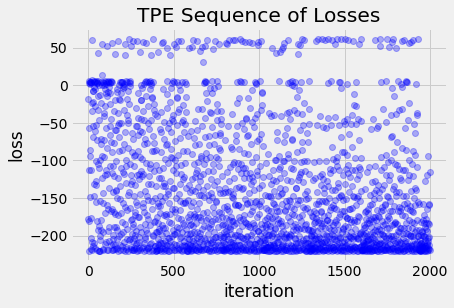

In [34]:
# Sort with best loss first
tpe_results = tpe_results.sort_values('loss', ascending = True).reset_index()

plt.plot(tpe_results['iteration'], tpe_results['loss'], 'bo', alpha = 0.3);
plt.xlabel('iteration'); plt.ylabel('loss'); plt.title('TPE Sequence of Losses');

print('Best Loss of {:.4f} occured at iteration {}'.format(tpe_results['loss'][0], tpe_results['iteration'][0]))

Here we see the main benefit of Bayesian model-based optimization: more concentration on promising input values. When we are searching over dozens of parameters and each eval takes hours or days, reducing the number of evals is critical. Bayesian optimization minimizes the number of evals by reasoning based on previous results what input values should be tried in the future.

<b><h2>Conclusions</h2></b>

Bayesian model-based optimization is intuitive: choose the next input values to evaluate based on the past results to concentrate the search on more promising values. The end outcome is a reduction in the total number of search iterations compared to uninformed random or grid search methods.